In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge_IIoTset__DatasetFL.pdf
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Readme.txt
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/Uploading attack.pcap
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/DDoS_ICMP_Flood_attack.csv
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/DDoS_TCP_SYN_Flood_attack.csv
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/MITM (ARP spoofing + DNS) Attack.pcap
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/Uploading_attack.csv
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/XSS_attack.csv
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/DDoS_UD

In [2]:
df = pd.read_csv('../input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv', low_memory=False)

In [3]:
features_with_one_unique_value = list(df.columns[df.nunique() == 1])

In [4]:
from sklearn.utils import shuffle
drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4","dns.qry.name",
         "http.file_data","http.request.full_uri","icmp.transmit_timestamp","arp.hw.size","icmp.seq_le",
         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport","arp.opcode","icmp.checksum",
         "tcp.dstport", "udp.port", "mqtt.msg"]+features_with_one_unique_value
df.drop(drop_columns, axis=1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(subset=None, keep="first", inplace=True)
df = shuffle(df)

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

encode_text_dummy(df,'http.request.method')
encode_text_dummy(df,'http.referer')
encode_text_dummy(df,"http.request.version")
encode_text_dummy(df,"dns.qry.name.len")
encode_text_dummy(df,"mqtt.conack.flags")
encode_text_dummy(df,"mqtt.protoname")
encode_text_dummy(df,"mqtt.topic")

In [6]:
X = df. drop(['Attack_type','Attack_label'],axis=1)
y = df['Attack_type']

In [7]:
import matplotlib.pyplot as plt
attack_type_counts = y.value_counts()

total_attacks = len(df)
percentages = (attack_type_counts / total_attacks) * 100

for attack_type, percentage in percentages.items():
    print(f'{attack_type}: {percentage:.2f}%')

Normal: 74.13%
DDoS_UDP: 6.54%
SQL_injection: 2.76%
DDoS_TCP: 2.72%
Vulnerability_scanner: 2.72%
Password: 2.72%
DDoS_HTTP: 2.64%
Uploading: 2.00%
Backdoor: 1.31%
Port_Scanning: 1.09%
XSS: 0.82%
Ransomware: 0.53%
MITM: 0.02%
Fingerprinting: 0.01%
DDoS_ICMP: 0.00%


In [8]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

label_col = "Attack_type"
feat_cols = list(df.columns)
feat_cols.remove(label_col)

target_percentage_normal = 0.25
minority_classes = ['Ransomware', 'MITM', 'Fingerprinting', 'DDoS_ICMP','XSS']
target_percentage_minority = 0.02

normal_mask = df[label_col] == 'Normal'
X_normal = df.loc[normal_mask, feat_cols]
y_normal = df.loc[normal_mask, label_col]

non_normal_mask = ~normal_mask
X_non_normal = df.loc[non_normal_mask, feat_cols]
y_non_normal = df.loc[non_normal_mask, label_col]

desired_normal_count = int(len(y_non_normal) * (target_percentage_normal / (1 - target_percentage_normal)))
X_normal_sampled = X_normal.sample(n=desired_normal_count, random_state=42)
y_normal_sampled = y_normal.loc[X_normal_sampled.index]

total_samples = len(df) - len(X_normal_sampled)  # Adjusted total after undersampling
target_count = int(total_samples * target_percentage_minority)

minority_mask = df[label_col].isin(minority_classes)
X_minority = df.loc[minority_mask, feat_cols]
y_minority = df.loc[minority_mask, label_col]

desired_samples = {cls: target_count for cls in minority_classes}

oversample = RandomOverSampler(sampling_strategy=desired_samples, random_state=42)
X_oversampled, y_oversampled = oversample.fit_resample(X_minority, y_minority)

X_balanced = pd.concat([X_normal_sampled, X_oversampled, X_non_normal])
y_balanced = pd.concat([y_normal_sampled, y_oversampled, y_non_normal])

balanced_df = pd.concat([X_balanced, y_balanced], axis=1).sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df[label_col].value_counts(normalize=True))


Attack_type
Normal                   0.197650
DDoS_UDP                 0.149804
SQL_injection            0.063342
DDoS_TCP                 0.062393
Vulnerability_scanner    0.062345
Password                 0.062229
XSS                      0.060654
DDoS_HTTP                0.060498
Ransomware               0.053953
Uploading                0.045870
MITM                     0.042326
Fingerprinting           0.042217
DDoS_ICMP                0.041881
Backdoor                 0.029941
Port_Scanning            0.024895
Name: proportion, dtype: float64


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=1, stratify=y_balanced)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train =  label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [11]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)
X_val = robust_scaler.transform(X_val)


In [12]:
X_train_shaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_shaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
input_shape=X_train_shaped.shape[1:]

In [14]:
num_classes=len(np.unique(y))

In [15]:
input_shape

(87, 1)

In [16]:
num_classes

15

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
def evaluate(y_test,y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred, average='weighted')
  precision = precision_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')
  return {
        "Accuracy": accuracy,
        "Error": 1 - accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1 Score": f1
    }

In [18]:
from  tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

2024-11-04 05:54:18.955432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 05:54:18.955485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 05:54:18.956923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

lstm_model = Sequential()
lstm_model.add(LSTM(units=256, activation='tanh', input_shape=input_shape, return_sequences=True))
lstm_model.add(LSTM(128, activation='tanh'))
lstm_model.add(Dense(num_classes, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 87, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,247 (1.77 MB)

 Trainable params: 463,247 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from keras.metrics import Recall
recall_metric = Recall()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[recall_metric])

In [22]:
lstm_model.fit(X_train, y_train_cat,
               epochs=20,
               batch_size=256,
               validation_data=(X_val, y_val_cat),
               callbacks=[early_stopping])

Epoch 1/20
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 68s 32ms/step - loss: 1.3251 - recall: 0.3509 - val_loss: 0.3117 - val_recall: 0.8369
Epoch 2/20
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - loss: 0.2855 - recall: 0.8513 - val_loss: 0.2433 - val_recall: 0.8613
Epoch 3/20
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - loss: 0.2282 - recall: 0.8759 - val_loss: 0.2037 - val_recall: 0.8999
Epoch 4/20
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - loss: 0.2109 - recall: 0.8912 - val_loss: 0.2168 - val_recall: 0.8926
Epoch 5/20
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - loss: 0.2015 - recall: 0.8997 - val_loss: 0.2090 - val_recall: 0.8959
Epoch 6/20
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - loss: 0.1876 - recall: 0.9078 - val_loss: 0.2066 - val_recall: 0.8949
Epoch 7/20
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - loss: 0.1901 - recall: 0.9037 - val_loss: 0.1902 - val_recall: 0.9006
Epoch 8/20
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - loss: 0.1806 - recall: 0.9087 - val_loss: 0.18

In [24]:
from sklearn.metrics import classification_report
predictions = lstm_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

5015/5015 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


In [25]:
report = evaluate(y_test, predicted_labels)
print(report)

{'Accuracy': 0.9370365292820021, 'Error': 0.0629634707179979, 'Recall': 0.9370365292820021, 'Precision': 0.9464891483461103, 'F1 Score': 0.9367882634091028}


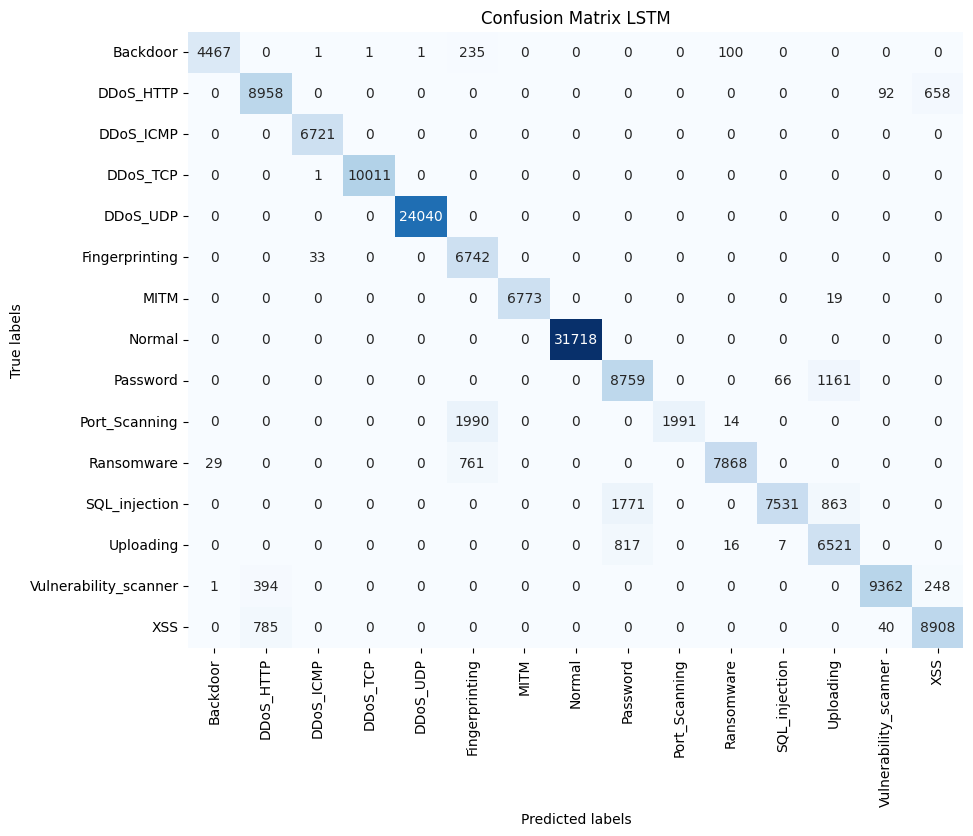

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = label_encoder.classes_ 

conf_matrix = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix LSTM')
plt.show()

In [27]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow import keras

inputs = keras.Input(shape=input_shape)

x = Conv1D(filters=32, kernel_size=3, padding="same", activation='relu')(inputs)
x = MaxPooling1D(strides=2)(x)

x = Conv1D(filters=64, kernel_size=3, padding="same", activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=2, padding="same")(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=2, padding="same")(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(15, activation='softmax')(x)

cnn_model = keras.Model(inputs=inputs, outputs=outputs)
cnn_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 87, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 87, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 43, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 43, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,599 (451.56 KB)

 Trainable params: 115,599 (451.56 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.optimizers import Adam
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=[recall_metric])

In [42]:
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
from keras.callbacks import EarlyStopping
EPOCHS=40
BATCH_SIZE=256
history = cnn_model.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_cnn)

Epoch 1/40
 51/851 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.4372 - recall: 0.5666

I0000 00:00:1730674015.195843     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1730674015.215951     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


851/851 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0204 - recall: 0.5387

W0000 00:00:1730674020.238590     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1730674021.053225     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


851/851 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 1.0200 - recall: 0.5387 - val_loss: 0.5894 - val_recall: 0.5966
Epoch 2/40
 33/851 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5960 - recall: 0.5948

W0000 00:00:1730674022.199153     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


851/851 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5795 - recall: 0.6016 - val_loss: 0.5630 - val_recall: 0.6314
Epoch 3/40
851/851 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5616 - recall: 0.6135 - val_loss: 0.5593 - val_recall: 0.6047
Epoch 4/40
851/851 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5426 - recall: 0.6276 - val_loss: 0.5197 - val_recall: 0.6177
Epoch 5/40
851/851 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5119 - recall: 0.6461 - val_loss: 0.4839 - val_recall: 0.6264
Epoch 6/40
851/851 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4838 - recall: 0.6520 - val_loss: 0.4718 - val_recall: 0.6507
Epoch 7/40
851/851 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4850 - recall: 0.6502 - val_loss: 0.4692 - val_recall: 0.6353
Epoch 8/40
851/851 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4686 - recall: 0.6586 - val_loss: 0.4647 - val_recall: 0.6526
Epoch 9/40
851/851 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4591 - recall: 0.6674 - val_loss: 0.4474 - val_recall: 0.6898
Epoch 10/40
851/851

In [ ]:
predictions_cnn = cnn_model.predict(X_test)
predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)

 114/2127 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

W0000 00:00:1730674147.379043     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2127/2127 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


W0000 00:00:1730674150.928729     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:
report = evaluate(y_test, predicted_labels_cnn)
print(report)

{'Accuracy': 0.8049873626050668, 'Error': 0.19501263739493324, 'Recall': 0.8049873626050668, 'Precision': 0.8689343630813012, 'F1 Score': 0.7993482885404306}


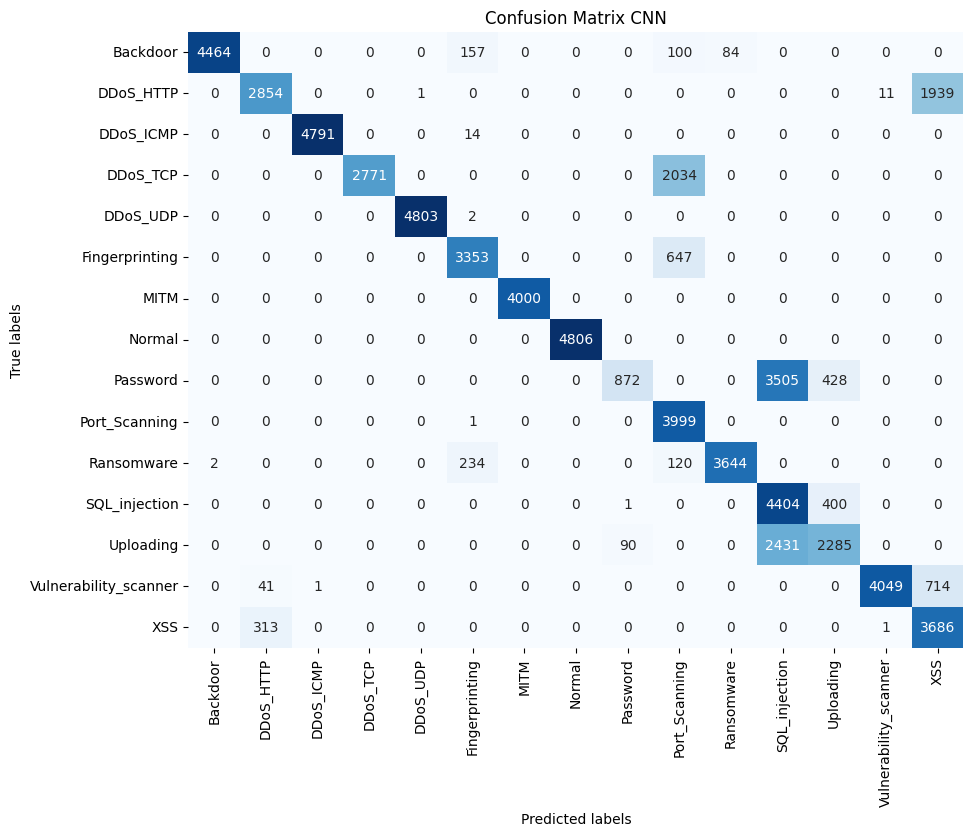

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = label_encoder.classes_ 

conf_matrix = confusion_matrix(y_test, predicted_labels_cnn)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix CNN')
plt.show()

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train_cat)

RandomForestClassifier()

In [35]:
y_test_pred_rf = rf_clf.predict(X_test)

y_test_pred_rf = np.argmax(y_test_pred_rf, axis=1)

eval_result = evaluate(y_test,y_test_pred_rf)
print(eval_result)

{'Accuracy': 0.9558059249473435, 'Error': 0.04419407505265649, 'Recall': 0.9558059249473435, 'Precision': 0.9570428995171473, 'F1 Score': 0.9557590129611511}


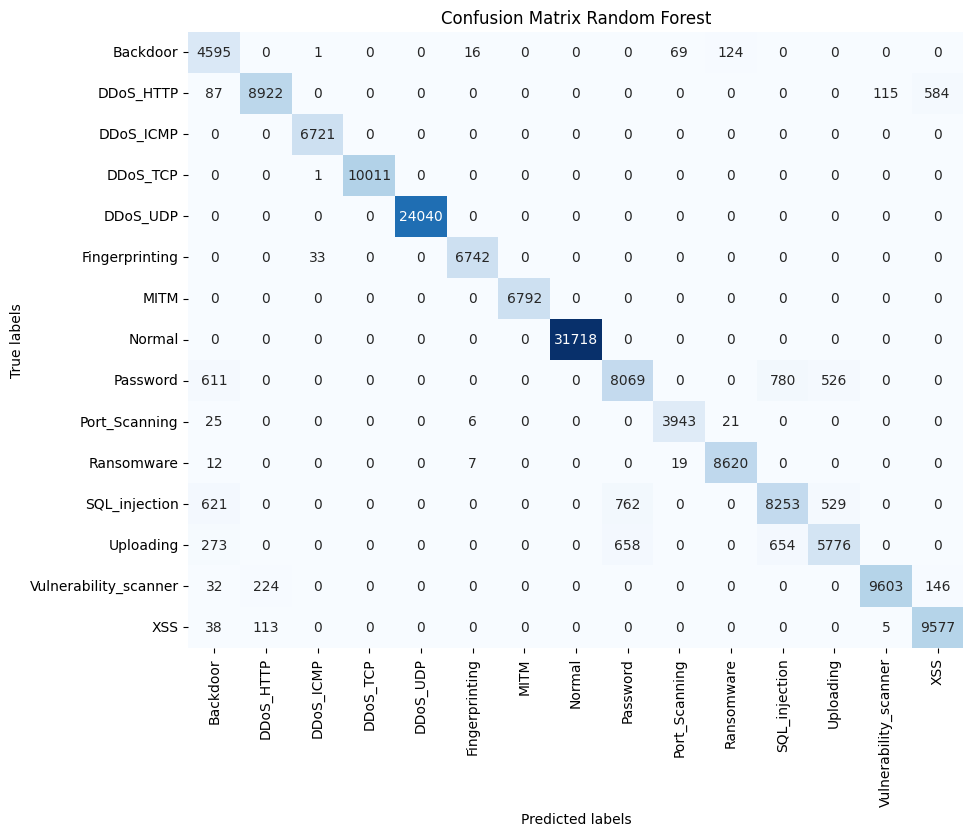

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = label_encoder.classes_ 

conf_matrix = confusion_matrix(y_test, y_test_pred_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Random Forest')
plt.show()

In [37]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
y_pred_xgb_1 = xgb.predict(X_test)
y_pred_xgb_1 = np.argmax(y_pred_xgb_1, axis=1)

eval_result = evaluate(y_test,y_pred_xgb_1)
print(eval_result)

{'Accuracy': 0.9376098308760298, 'Error': 0.06239016912397022, 'Recall': 0.9376098308760298, 'Precision': 0.9604752318323909, 'F1 Score': 0.9431742535743808}


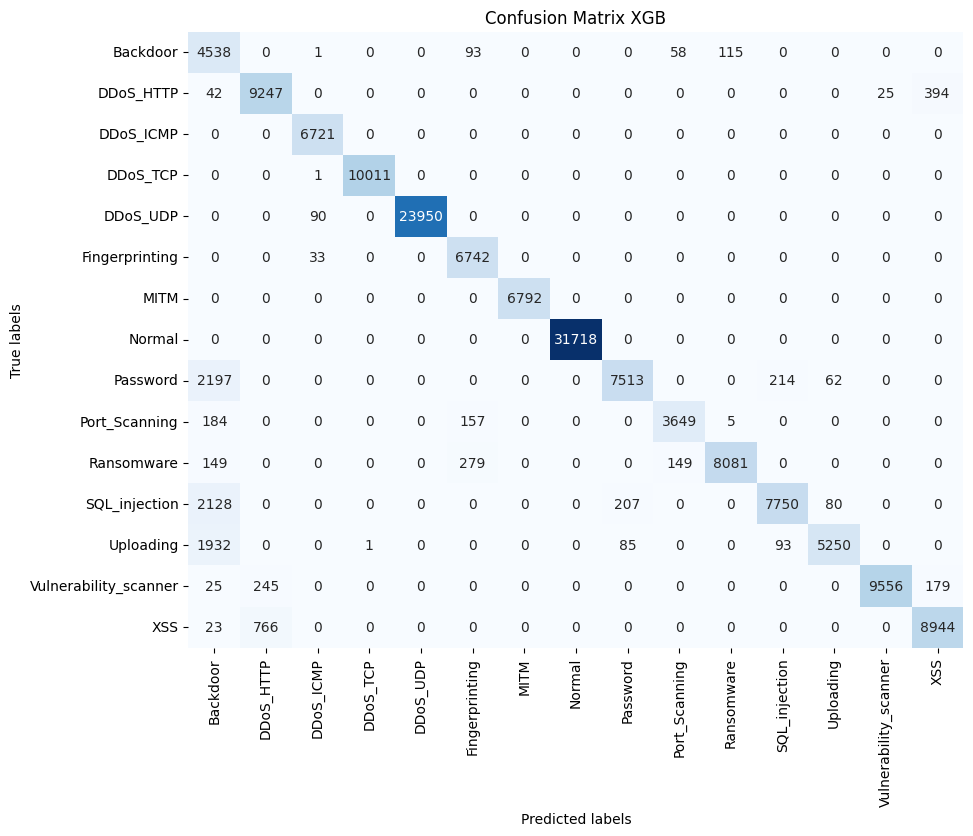

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = label_encoder.classes_  # Assuming label_encoder is your label encoder object

conf_matrix = confusion_matrix(y_test, y_pred_xgb_1)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix XGB')
plt.show()